In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import psycopg2

from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

pd.set_option("display.max_rows", 1000)

In [74]:
CONFIG_DIR = Path("../config/")
DATA_DIR = Path("../data/")

def get_creds(name):
    with CONFIG_DIR.joinpath("cfg_02_creds.json").open(encoding="utf-8") as data:
        return json.load(data).get(name)
    
creds = get_creds("hackathon_hst")
with psycopg2.connect(**creds) as conn:
    with conn.cursor() as cur:
        query = """select * 
                     from public.data_1m
                """
        cur.execute(query)
        cols = [desc[0] for desc in cur.description]
        raw_data = pd.DataFrame(cur.fetchall(), columns=cols)

In [75]:
data = raw_data.copy()

In [ ]:
print(data.head(10))
print("###############################")
print(data["target"].value_counts())

In [77]:
orig = pd.DataFrame()
orig["light"] = data["light"]
orig["nearby"] = data["nearby"]
orig["weather"] = data["weather"]
orig["road_conditions"] = data["road_conditions"] 

In [86]:
data["light"] = LabelEncoder().fit_transform(data["light"])
data["nearby"] = LabelEncoder().fit_transform(data["nearby"])
data["weather"] = LabelEncoder().fit_transform(data["weather"])
data["road_conditions"] = LabelEncoder().fit_transform(data["road_conditions"])

#x = data[["light", "nearby", "weather", "road_conditions", "day", "hour"]]
data[["light", "weather", "day", "hour"]]
y = data["target"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [87]:
#knn = KNeighborsClassifier(n_neighbors=3)
#knn.fit(x, y)
#print("KNN:".rjust(35), round(svm.score(x, y), 4))

#svm = make_pipeline(StandardScaler(), SVC(gamma="auto"))
#svm.fit(x, y)
#print("SVM:".rjust(35), round(svm.score(x, y), 4))

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
print("Decision Tree Classifier:".rjust(35), round(dtc.score(x_test, y_test), 4))

rc = RidgeClassifier(alpha=1.0)
rc.fit(x_train, y_train)
print("Ridge Classifier:".rjust(35), round(rc.score(x_test, y_test), 4))

rfc = RandomForestClassifier(max_depth=3, random_state=0)
rfc.fit(x_train, y_train)
print("(Bagging) Random Forest Classifier:".rjust(35), round(rfc.score(x_test, y_test), 4))

#abc = AdaBoostClassifier(n_estimators=100, random_state=0)
#abc.fit(x_train, y_train)
#print("(Boosting) Ada Boost Classifier:".rjust(35), round(abc.score(x_test, y_test), 4))

#estimators = [
#    ("rfc", RandomForestClassifier(n_estimators=10, random_state=42)), 
#    ("svc", make_pipeline(StandardScaler(), LinearSVC(random_state=42)))
#]

#sc = StackingClassifier(estimators = estimators, final_estimator=LogisticRegression())
#sc.fit(x, y)
#print("(Stacking) Classifier:".rjust(35), round(sc.score(x, y), 4))

          Decision Tree Classifier: 0.8452
                  Ridge Classifier: 0.9039
(Bagging) Random Forest Classifier: 0.9039


In [98]:
results = pd.DataFrame()
results["light"] = x_test["light"]
results["nearby"] = x_test["nearby"]
results["weather"] = x_test["weather"]
results["road_conditions"] = x_test["road_conditions"]
results["day"] = x_test["day"]
results["hour"] = x_test["hour"]
results["#1"] = "#"
results["target"] = y_test
results["#2"] = "#"
#results["knn"] = knn.predict(x)
#results["svm"] = svm.predict(x)
results["dtc"] = dtc.predict(x_test)
results["rc"] = rc.predict(x_test)
results["rfc"] = rfc.predict(x_test)
#results["abc"] = abc.predict(x)
#results["sc"] = sc.predict(x)

In [100]:
print(results["target"].value_counts())

0     333527
1      31115
2       3186
3        760
4        261
5         80
6         24
7          9
9          5
8          3
17         1
11         1
10         1
14         1
15         1
19         1
12         1
Name: target, dtype: int64


In [106]:
#results.head(10)
results.where((results.target == results.dtc) & (results.target == 3)).dropna()

,light,nearby,weather,road_conditions,day,hour,#1,target,#2,dtc,rc,rfc
114388,2.0,45222.0,32.0,4531.0,20,18,#,3.0,#,3.0,0.0,0.0


In [ ]:
results["weather"].value_counts()

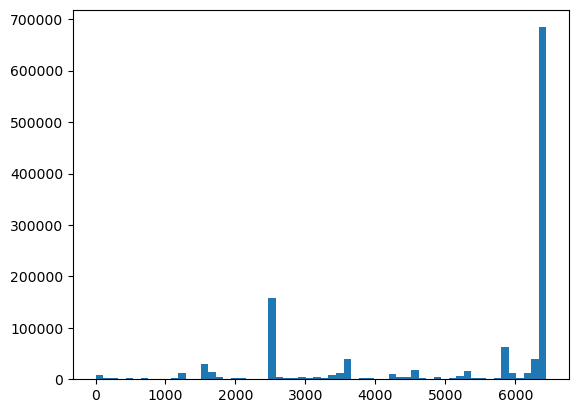

In [73]:
plt.hist(results["road_conditions"], bins=60)
plt.show()